Specifically, in this post, I'll talk about:

-Matrix Factorisation in Keras

-Adding non-negativitiy constraints to solve non-negative matrix factorisation (NNMF)

-Using neural networks for recommendations

# Select dataset to process

In [1]:
#@title
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dt_dir_name= "C:/Users/MoNguyen/Desktop/Mo/sample_data/ml-100k/"

In [3]:
#dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset = pd.read_csv(dt_dir_name +'/'+ 'ml100k_ns.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])




In [4]:
dataset.head()

user_id  item_id  rating  timestamp
0      196      242       1  881250949
1      186      302       1  891717742
2       22      377       1  878887116
3      244       51       1  880606923
4      166      346       1  886397596

In [5]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

We assign a unique number between (0, #users) to each user and do the same for movies.


In [6]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [7]:
dataset.head()

user_id  item_id  rating  timestamp
0      195      241       1  881250949
1      185      301       1  891717742
2       21      376       1  878887116
3      243       50       1  880606923
4      165      345       1  886397596

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset.rating = scaler.fit_transform(dataset[['rating']])

In [9]:
dataset.tail()

user_id  item_id  rating  timestamp
399995      879      475     1.0  880175444
399996      715      203     1.0  879795543
399997      275     1089     1.0  874795795
399998       12      224     1.0  882399156
399999       11      202     1.0  879959583

In [10]:
X = dataset.loc[[1,2,3],['user_id', 'item_id']]
X

user_id  item_id
1      185      301
2       21      376
3      243       50

In [11]:
train, test = train_test_split(dataset, test_size=0.2)

One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: $A≈W.HT$

In [12]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
import math


#Create MF model using Keras

In [13]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 16

In [14]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors, embeddings_regularizer=l2(1e-6), name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users, n_latent_factors, embeddings_regularizer=l2(1e-6), name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','MAPE','mse'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        26912       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        15088       User[0][0]                       
______________________________________________________________________________________________

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [17]:
dataset.index

RangeIndex(start=0, stop=400000, step=1)

##Create data generator class

The class generate the sample for training dynamically

In [18]:
class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size=16, dim=(1), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = dataset.index
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(len(self.dataset) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]

        # Find list of IDs
        list_IDs_temp = [self.indexes[k] for k in idxs]

        # Generate data
        User = dataset.loc[list_IDs_temp,['user_id']].to_numpy()#.reshape(-1)
        Item = dataset.loc[list_IDs_temp,['item_id']].to_numpy()#.reshape(-1)
        y = dataset.loc[list_IDs_temp,['rating']].to_numpy()#.reshape(-1)
        #print("u,i,r:", [User, Item],[y])
        return [User, Item],[y]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


##Trainging the model (2 options)

 - Normal fit
 - Fit generator

In [33]:
#1 Normal training with fit method (uncomment to run)

#history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

In [19]:
#2  training with fit generator
train_generator = DataGenerator(dataset=train, batch_size=256)
history = model.fit(train_generator, epochs=10)

Train for 1250 steps
Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 4.6204 - Accuracy: 0.0000e+00 - MAPE: 2799526.0000 - mse: 0.4971
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 2.3154 - Accuracy: 0.0000e+00 - MAPE: 10179926.0000 - mse: 0.4700
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5249 - Accuracy: 0.0000e+00 - MAPE: 25236194.0000 - mse: 0.4267
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1391 - Accuracy: 0.0000e+00 - MAPE: 48390136.0000 - mse: 0.3657
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8691 - Accuracy: 0.0000e+00 - MAPE: 79326672.0000 - mse: 0.2942
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6918 - Accuracy: 0.0000e+00 - MAPE: 108262576.0000 - mse: 0.2340
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5891 - Accuracy: 0.0000e+00 - MAPE: 125728704.000

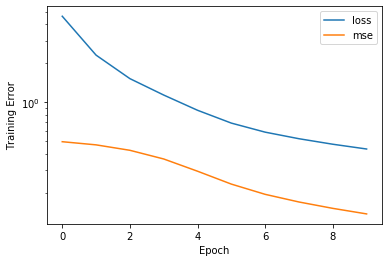

In [23]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['mse']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','mse'])

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [24]:
results = model.evaluate((test.user_id, test.item_id), test.rating,
                            batch_size=1)

80000/80000 [==============================] - 47s 586us/sample - loss: 0.4159 - Accuracy: 0.0000e+00 - MAPE: 135739824.0000 - mse: 0.1305


In [25]:
print(results)

[0.41593597174513564, 0.0, 135739820.0, 0.13052726]


In [30]:
#y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_hat = model.predict([test.user_id, test.item_id])
y_true = test.rating
print('y_hat:', y_hat)
print('y_true',y_true)

y_hat: [[ 0.69771755]
 [ 0.00341872]
 [ 0.48514423]
 ...
 [-0.22944476]
 [-0.0697553 ]
 [ 0.7751138 ]]
y_true 18881     1.0
285857    0.0
249145    0.0
93951     1.0
2426      1.0
         ... 
377632    1.0
22769     1.0
175016    0.0
179031    0.0
51894     1.0
Name: rating, Length: 80000, dtype: float64


In [31]:
#y_score.as_matrix=[y_true]
y_score=y_hat
y_score

array([[ 0.69771755],
       [ 0.00341872],
       [ 0.48514423],
       ...,
       [-0.22944476],
       [-0.0697553 ],
       [ 0.7751138 ]], dtype=float32)

In [32]:
y_true=y_true.to_numpy()
print (y_true)

[1. 0. 0. ... 0. 0. 1.]


In [33]:
#y_temp=y_score.round()
y_temp=y_score
y_temp=y_temp.transpose()
y_true.shape=(1,80000)

In [280]:
print(type(y_temp))
print(y_temp)
print(y_temp.shape)

print(type(y_true))
print(y_true)
print(y_true.shape)

<class 'numpy.ndarray'>
[[ 0.02484813  0.798125   -0.08063883 ...  1.757946    0.35254914
   1.7926122 ]]
(1, 80000)
<class 'numpy.ndarray'>
[[0. 1. 0. ... 1. 1. 1.]]
(1, 80000)


In [281]:
#NDCG calculation
from sklearn.metrics import ndcg_score
#ndcg_score(y_true, y_hat,k=1,ignore_ties=True)
ndcg_score(y_true, y_temp, k=1, sample_weight=None, ignore_ties=False)

1.0

In [282]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
#y_true = np.array([[1, 0, 0], [0, 0, 1]])
#y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
label_ranking_average_precision_score(y_true, y_temp)

0.9528014598204647

In [284]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_temp)

0.6790829628332707

In [51]:
from sklearn.metrics import log_loss
sklearn.metrics.log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)

nan

#Extracting the learnt embeddings
We can extract the learnt movie and item embeddings as follows:

In [ ]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

In [ ]:
user_embedding_learnt

In [ ]:
user_embedding_learnt.shape

In [ ]:
#SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

#Recommend top n movies

In [ ]:
def recommend(user_id, number_of_movies=5):
  movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
  mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
  return mids

In [ ]:
recommend(user_id=1)

#Experimental results:
A. NO scale
1. array([ 482,   56, 1462, 1397, 1642]) --> normal training (fit) 100 epoches
2. array([1638,  118, 1466, 1448, 1627]) --> generator training (fit_generator) 20 epoches
3. array([ 901,  319, 1404, 1448, 1642])--> generator training (fit_generator) 50 epoches
4. array([1642,  614,  588, 1193,  640]) --> GT 100 ep

#References
https://nipunbatra.github.io/blog/2017/recommend-keras.html

https://medium.com/sfu-big-data/recommendation-systems-collaborative-filtering-using-matrix-factorization-simplified-2118f4ef2cd3

[Keras regularizer](https://keras.io/regularizers/)